#  Forked from [Baseline Modeling](https://www.kaggle.com/wrosinski/baselinemodeling)

## Added Image features from [Extract Image features from pretrained NN](https://www.kaggle.com/christofhenkel/extract-image-features-from-pretrained-nn)

## Added Image size features from [Extract Image Features](https://www.kaggle.com/kaerunantoka/extract-image-features)

In [1]:
import gc
import glob
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import warnings

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from joblib import Parallel, delayed
from tqdm import tqdm, tqdm_notebook

%matplotlib inline

np.random.seed(seed=1337)
warnings.filterwarnings('ignore')

split_char = '/'
PETFINDER_ROOT_PATH = '/media/markytools/503f6b96-90ca-4bfb-a99e-35f774205c77/EEE298/petfinder-adoption-prediction'
KERAS_PRETRAINED_PATH = '/media/markytools/503f6b96-90ca-4bfb-a99e-35f774205c77/keras-pretrained/densenet-keras'

In [2]:
train = pd.read_csv(PETFINDER_ROOT_PATH + '/train/train.csv')
test = pd.read_csv(PETFINDER_ROOT_PATH + '/test/test.csv')
sample_submission = pd.read_csv(PETFINDER_ROOT_PATH + '/test/sample_submission.csv')

## Image features

In [3]:
import cv2
import os
from keras.applications.densenet import preprocess_input, DenseNet121

Using TensorFlow backend.


In [4]:
def resize_to_square(im):
    old_size = im.shape[:2]
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im

def load_image(path, pet_id):
    image = cv2.imread(f'{path}{pet_id}-1.jpg')
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image

In [5]:
img_size = 256
batch_size = 256

In [6]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K
inp = Input((256,256,3))
backbone = DenseNet121(input_tensor = inp, 
                       weights=KERAS_PRETRAINED_PATH + "/DenseNet-BC-121-32-no-top.h5",
                       include_top = False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)
x = AveragePooling1D(4)(x)
out = Lambda(lambda x: x[:,:,0])(x)

m = Model(inp,out)

In [7]:
pet_ids = train['PetID'].values
n_batches = len(pet_ids) // batch_size + 1

features = {}
for b in tqdm(range(n_batches)):
    start = b*batch_size
    end = (b+1)*batch_size
    batch_pets = pet_ids[start:end]
    batch_images = np.zeros((len(batch_pets),img_size,img_size,3))
    for i,pet_id in enumerate(batch_pets):
        try:
            batch_images[i] = load_image(PETFINDER_ROOT_PATH +  + "/train_images/", pet_id)
        except:
            pass
    batch_preds = m.predict(batch_images)
    for i,pet_id in enumerate(batch_pets):
        features[pet_id] = batch_preds[i]

100%|██████████| 59/59 [00:58<00:00,  1.10it/s]


In [8]:
train_feats = pd.DataFrame.from_dict(features, orient='index')
train_feats.columns = [f'pic_{i}' for i in range(train_feats.shape[1])]

In [9]:
pet_ids = test['PetID'].values
n_batches = len(pet_ids) // batch_size + 1

features = {}
for b in tqdm(range(n_batches)):
    start = b*batch_size
    end = (b+1)*batch_size
    batch_pets = pet_ids[start:end]
    batch_images = np.zeros((len(batch_pets),img_size,img_size,3))
    for i,pet_id in enumerate(batch_pets):
        try:
            batch_images[i] = load_image(PETFINDER_ROOT_PATH + "/test_images/", pet_id)
        except:
            pass
    batch_preds = m.predict(batch_images)
    for i,pet_id in enumerate(batch_pets):
        features[pet_id] = batch_preds[i]

100%|██████████| 16/16 [00:25<00:00,  1.41s/it]


In [10]:
test_feats = pd.DataFrame.from_dict(features, orient='index')
test_feats.columns = [f'pic_{i}' for i in range(test_feats.shape[1])]

In [11]:
train_feats = train_feats.reset_index()
train_feats.rename({'index': 'PetID'}, axis='columns', inplace=True)

test_feats = test_feats.reset_index()
test_feats.rename({'index': 'PetID'}, axis='columns', inplace=True)

In [12]:
all_ids = pd.concat([train, test], axis=0, ignore_index=True, sort=False)[['PetID']]
all_ids.shape

(18941, 1)

In [13]:
n_components = 32
svd_ = TruncatedSVD(n_components=n_components, random_state=1337)

features_df = pd.concat([train_feats, test_feats], axis=0)
features = features_df[[f'pic_{i}' for i in range(256)]].values

svd_col = svd_.fit_transform(features)
svd_col = pd.DataFrame(svd_col)
svd_col = svd_col.add_prefix('IMG_SVD_')

img_features = pd.concat([all_ids, svd_col], axis=1)

## About metadata and sentiment

In [14]:
labels_breed = pd.read_csv(PETFINDER_ROOT_PATH + '/breed_labels.csv')
labels_state = pd.read_csv(PETFINDER_ROOT_PATH + '/color_labels.csv')
labels_color = pd.read_csv(PETFINDER_ROOT_PATH + '/state_labels.csv')

In [15]:
train_image_files = sorted(glob.glob(PETFINDER_ROOT_PATH + '/train_images/*.jpg'))
train_metadata_files = sorted(glob.glob(PETFINDER_ROOT_PATH + '/train_metadata/*.json'))
train_sentiment_files = sorted(glob.glob(PETFINDER_ROOT_PATH + '/train_sentiment/*.json'))

print(f'num of train images files: {len(train_image_files)}')
print(f'num of train metadata files: {len(train_metadata_files)}')
print(f'num of train sentiment files: {len(train_sentiment_files)}')


test_image_files = sorted(glob.glob(PETFINDER_ROOT_PATH + '/test_images/*.jpg'))
test_metadata_files = sorted(glob.glob(PETFINDER_ROOT_PATH + '/test_metadata/*.json'))
test_sentiment_files = sorted(glob.glob(PETFINDER_ROOT_PATH + '/test_sentiment/*.json'))

print(f'num of test images files: {len(test_image_files)}')
print(f'num of test metadata files: {len(test_metadata_files)}')
print(f'num of test sentiment files: {len(test_sentiment_files)}')

num of train images files: 58311
num of train metadata files: 58311
num of train sentiment files: 14442
num of test images files: 15040
num of test metadata files: 15040
num of test sentiment files: 3815


### Train

In [16]:
# Images:
train_df_ids = train[['PetID']]
print(train_df_ids.shape)

# Metadata:
train_df_ids = train[['PetID']]
train_df_metadata = pd.DataFrame(train_metadata_files)
train_df_metadata.columns = ['metadata_filename']
train_metadata_pets = train_df_metadata['metadata_filename'].apply(lambda x: x.split(split_char)[-1].split('-')[0])
train_df_metadata = train_df_metadata.assign(PetID=train_metadata_pets)
print(len(train_metadata_pets.unique()))

pets_with_metadatas = len(np.intersect1d(train_metadata_pets.unique(), train_df_ids['PetID'].unique()))
print(f'fraction of pets with metadata: {pets_with_metadatas / train_df_ids.shape[0]:.3f}')

# Sentiment:
train_df_ids = train[['PetID']]
train_df_sentiment = pd.DataFrame(train_sentiment_files)
train_df_sentiment.columns = ['sentiment_filename']
train_sentiment_pets = train_df_sentiment['sentiment_filename'].apply(lambda x: x.split(split_char)[-1].split('.')[0])
train_df_sentiment = train_df_sentiment.assign(PetID=train_sentiment_pets)
print(len(train_sentiment_pets.unique()))

pets_with_sentiments = len(np.intersect1d(train_sentiment_pets.unique(), train_df_ids['PetID'].unique()))
print(f'fraction of pets with sentiment: {pets_with_sentiments / train_df_ids.shape[0]:.3f}')

(14993, 1)
14652
fraction of pets with metadata: 0.977
14442
fraction of pets with sentiment: 0.963


### Test

In [17]:
# Images:
test_df_ids = test[['PetID']]
print(test_df_ids.shape)

# Metadata:
test_df_metadata = pd.DataFrame(test_metadata_files)
test_df_metadata.columns = ['metadata_filename']
test_metadata_pets = test_df_metadata['metadata_filename'].apply(lambda x: x.split(split_char)[-1].split('-')[0])
test_df_metadata = test_df_metadata.assign(PetID=test_metadata_pets)
print(len(test_metadata_pets.unique()))

pets_with_metadatas = len(np.intersect1d(test_metadata_pets.unique(), test_df_ids['PetID'].unique()))
print(f'fraction of pets with metadata: {pets_with_metadatas / test_df_ids.shape[0]:.3f}')

# Sentiment:
test_df_sentiment = pd.DataFrame(test_sentiment_files)
test_df_sentiment.columns = ['sentiment_filename']
test_sentiment_pets = test_df_sentiment['sentiment_filename'].apply(lambda x: x.split(split_char)[-1].split('.')[0])
test_df_sentiment = test_df_sentiment.assign(PetID=test_sentiment_pets)
print(len(test_sentiment_pets.unique()))

pets_with_sentiments = len(np.intersect1d(test_sentiment_pets.unique(), test_df_ids['PetID'].unique()))
print(f'fraction of pets with sentiment: {pets_with_sentiments / test_df_ids.shape[0]:.3f}')

(3948, 1)
3821
fraction of pets with metadata: 0.968
3815
fraction of pets with sentiment: 0.966


## Extract features from json

In [18]:
class PetFinderParser(object):
    
    def __init__(self, debug=False):
        
        self.debug = debug
        self.sentence_sep = ' '
        
        self.extract_sentiment_text = False
    
    def open_json_file(self, filename):
        with open(filename, 'r', encoding='utf-8') as f:
            json_file = json.load(f)
        return json_file
        
    def parse_sentiment_file(self, file):
        """
        Parse sentiment file. Output DF with sentiment features.
        """
        
        file_sentiment = file['documentSentiment']
        file_entities = [x['name'] for x in file['entities']]
        file_entities = self.sentence_sep.join(file_entities)
        
        file_sentences_sentiment = [x['sentiment'] for x in file['sentences']]
        
        file_sentences_sentiment = pd.DataFrame.from_dict(
            file_sentences_sentiment, orient='columns')
        file_sentences_sentiment_df = pd.DataFrame(
            {
                'magnitude_sum': file_sentences_sentiment['magnitude'].sum(axis=0),
                'score_sum': file_sentences_sentiment['score'].sum(axis=0),
                'magnitude_mean': file_sentences_sentiment['magnitude'].mean(axis=0),
                'score_mean': file_sentences_sentiment['score'].mean(axis=0),
                'magnitude_var': file_sentences_sentiment['magnitude'].var(axis=0),
                'score_var': file_sentences_sentiment['score'].var(axis=0),
            }, index=[0]
        )
        
        df_sentiment = pd.DataFrame.from_dict(file_sentiment, orient='index').T
        df_sentiment = pd.concat([df_sentiment, file_sentences_sentiment_df], axis=1)
            
        df_sentiment['entities'] = file_entities
        df_sentiment = df_sentiment.add_prefix('sentiment_')
        
        return df_sentiment
    
    def parse_metadata_file(self, file):
        """
        Parse metadata file. Output DF with metadata features.
        """
        
        file_keys = list(file.keys())
        
        if 'labelAnnotations' in file_keys:
            file_annots = file['labelAnnotations']
            file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
            file_top_desc = [x['description'] for x in file_annots]
        else:
            file_top_score = np.nan
            file_top_desc = ['']
        
        file_colors = file['imagePropertiesAnnotation']['dominantColors']['colors']
        file_crops = file['cropHintsAnnotation']['cropHints']

        file_color_score = np.asarray([x['score'] for x in file_colors]).mean()
        file_color_pixelfrac = np.asarray([x['pixelFraction'] for x in file_colors]).mean()

        file_crop_conf = np.asarray([x['confidence'] for x in file_crops]).mean()
        
        if 'importanceFraction' in file_crops[0].keys():
            file_crop_importance = np.asarray([x['importanceFraction'] for x in file_crops]).mean()
        else:
            file_crop_importance = np.nan

        df_metadata = {
            'annots_score': file_top_score,
            'color_score': file_color_score,
            'color_pixelfrac': file_color_pixelfrac,
            'crop_conf': file_crop_conf,
            'crop_importance': file_crop_importance,
            'annots_top_desc': self.sentence_sep.join(file_top_desc)
        }
        
        df_metadata = pd.DataFrame.from_dict(df_metadata, orient='index').T
        df_metadata = df_metadata.add_prefix('metadata_')
        
        return df_metadata
    

def extract_additional_features(pet_id, mode='train'):
    
    sentiment_filename = f'{PETFINDER_ROOT_PATH}/{mode}_sentiment/{pet_id}.json'
    try:
        sentiment_file = pet_parser.open_json_file(sentiment_filename)
        df_sentiment = pet_parser.parse_sentiment_file(sentiment_file)
        df_sentiment['PetID'] = pet_id
    except FileNotFoundError:
        df_sentiment = []

    dfs_metadata = []
    metadata_filenames = sorted(glob.glob(f'{PETFINDER_ROOT_PATH}/{mode}_metadata/{pet_id}*.json'))
    if len(metadata_filenames) > 0:
        for f in metadata_filenames:
            metadata_file = pet_parser.open_json_file(f)
            df_metadata = pet_parser.parse_metadata_file(metadata_file)
            df_metadata['PetID'] = pet_id
            dfs_metadata.append(df_metadata)
        dfs_metadata = pd.concat(dfs_metadata, ignore_index=True, sort=False)
    dfs = [df_sentiment, dfs_metadata]
    
    return dfs


pet_parser = PetFinderParser()

In [19]:
debug = False
train_pet_ids = train.PetID.unique()
test_pet_ids = test.PetID.unique()

if debug:
    train_pet_ids = train_pet_ids[:1000]
    test_pet_ids = test_pet_ids[:500]


dfs_train = Parallel(n_jobs=-1, verbose=1)(
    delayed(extract_additional_features)(i, mode='train') for i in train_pet_ids)

train_dfs_sentiment = [x[0] for x in dfs_train if isinstance(x[0], pd.DataFrame)]
train_dfs_metadata = [x[1] for x in dfs_train if isinstance(x[1], pd.DataFrame)]

train_dfs_sentiment = pd.concat(train_dfs_sentiment, ignore_index=True, sort=False)
train_dfs_metadata = pd.concat(train_dfs_metadata, ignore_index=True, sort=False)

print(train_dfs_sentiment.shape, train_dfs_metadata.shape)


dfs_test = Parallel(n_jobs=-1, verbose=1)(
    delayed(extract_additional_features)(i, mode='test') for i in test_pet_ids)

test_dfs_sentiment = [x[0] for x in dfs_test if isinstance(x[0], pd.DataFrame)]
test_dfs_metadata = [x[1] for x in dfs_test if isinstance(x[1], pd.DataFrame)]

test_dfs_sentiment = pd.concat(test_dfs_sentiment, ignore_index=True, sort=False)
test_dfs_metadata = pd.concat(test_dfs_metadata, ignore_index=True, sort=False)

print(test_dfs_sentiment.shape, test_dfs_metadata.shape)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 2148 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 3448 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 4948 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6648 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 8548 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 10648 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 12948 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 14978 out of 14993 | elapsed:  3.8min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 14993 out of 14993 | elapsed:  3.8min finished


(14442, 10) (58311, 7)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 3948 out of 3948 | elapsed:   21.7s finished


(3815, 10) (15040, 7)


### group extracted features by PetID:

In [20]:
aggregates = ['sum', 'mean', 'var']
sent_agg = ['sum']


# Train
train_metadata_desc = train_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
train_metadata_desc = train_metadata_desc.reset_index()
train_metadata_desc[
    'metadata_annots_top_desc'] = train_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

prefix = 'metadata'
train_metadata_gr = train_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in train_metadata_gr.columns:
    if 'PetID' not in i:
        train_metadata_gr[i] = train_metadata_gr[i].astype(float)
train_metadata_gr = train_metadata_gr.groupby(['PetID']).agg(aggregates)
train_metadata_gr.columns = pd.Index([f'{c[0]}_{c[1].upper()}' for c in train_metadata_gr.columns.tolist()])
train_metadata_gr = train_metadata_gr.reset_index()


train_sentiment_desc = train_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
train_sentiment_desc = train_sentiment_desc.reset_index()
train_sentiment_desc[
    'sentiment_entities'] = train_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(x))

prefix = 'sentiment'
train_sentiment_gr = train_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in train_sentiment_gr.columns:
    if 'PetID' not in i:
        train_sentiment_gr[i] = train_sentiment_gr[i].astype(float)
train_sentiment_gr = train_sentiment_gr.groupby(['PetID']).agg(sent_agg)
train_sentiment_gr.columns = pd.Index([f'{c[0]}' for c in train_sentiment_gr.columns.tolist()])
train_sentiment_gr = train_sentiment_gr.reset_index()


# Test
test_metadata_desc = test_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
test_metadata_desc = test_metadata_desc.reset_index()
test_metadata_desc[
    'metadata_annots_top_desc'] = test_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

prefix = 'metadata'
test_metadata_gr = test_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in test_metadata_gr.columns:
    if 'PetID' not in i:
        test_metadata_gr[i] = test_metadata_gr[i].astype(float)
test_metadata_gr = test_metadata_gr.groupby(['PetID']).agg(aggregates)
test_metadata_gr.columns = pd.Index([f'{c[0]}_{c[1].upper()}' for c in test_metadata_gr.columns.tolist()])
test_metadata_gr = test_metadata_gr.reset_index()


test_sentiment_desc = test_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
test_sentiment_desc = test_sentiment_desc.reset_index()
test_sentiment_desc[
    'sentiment_entities'] = test_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(x))

prefix = 'sentiment'
test_sentiment_gr = test_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in test_sentiment_gr.columns:
    if 'PetID' not in i:
        test_sentiment_gr[i] = test_sentiment_gr[i].astype(float)
test_sentiment_gr = test_sentiment_gr.groupby(['PetID']).agg(sent_agg)
test_sentiment_gr.columns = pd.Index([f'{c[0]}' for c in test_sentiment_gr.columns.tolist()])
test_sentiment_gr = test_sentiment_gr.reset_index()

### merge processed DFs with base train/test DF:

In [21]:
# Train merges:
train_proc = train.copy()
train_proc = train_proc.merge(
    train_sentiment_gr, how='left', on='PetID')
train_proc = train_proc.merge(
    train_metadata_gr, how='left', on='PetID')
train_proc = train_proc.merge(
    train_metadata_desc, how='left', on='PetID')
train_proc = train_proc.merge(
    train_sentiment_desc, how='left', on='PetID')

# Test merges:
test_proc = test.copy()
test_proc = test_proc.merge(
    test_sentiment_gr, how='left', on='PetID')
test_proc = test_proc.merge(
    test_metadata_gr, how='left', on='PetID')
test_proc = test_proc.merge(
    test_metadata_desc, how='left', on='PetID')
test_proc = test_proc.merge(
    test_sentiment_desc, how='left', on='PetID')

print(train_proc.shape, test_proc.shape)
assert train_proc.shape[0] == train.shape[0]
assert test_proc.shape[0] == test.shape[0]

(14993, 49) (3948, 48)


In [22]:
train_breed_main = train_proc[['Breed1']].merge(
    labels_breed, how='left',
    left_on='Breed1', right_on='BreedID',
    suffixes=('', '_main_breed'))

train_breed_main = train_breed_main.iloc[:, 2:]
train_breed_main = train_breed_main.add_prefix('main_breed_')

train_breed_second = train_proc[['Breed2']].merge(
    labels_breed, how='left',
    left_on='Breed2', right_on='BreedID',
    suffixes=('', '_second_breed'))

train_breed_second = train_breed_second.iloc[:, 2:]
train_breed_second = train_breed_second.add_prefix('second_breed_')


train_proc = pd.concat(
    [train_proc, train_breed_main, train_breed_second], axis=1)


test_breed_main = test_proc[['Breed1']].merge(
    labels_breed, how='left',
    left_on='Breed1', right_on='BreedID',
    suffixes=('', '_main_breed'))

test_breed_main = test_breed_main.iloc[:, 2:]
test_breed_main = test_breed_main.add_prefix('main_breed_')

test_breed_second = test_proc[['Breed2']].merge(
    labels_breed, how='left',
    left_on='Breed2', right_on='BreedID',
    suffixes=('', '_second_breed'))

test_breed_second = test_breed_second.iloc[:, 2:]
test_breed_second = test_breed_second.add_prefix('second_breed_')


test_proc = pd.concat(
    [test_proc, test_breed_main, test_breed_second], axis=1)

print(train_proc.shape, test_proc.shape)

(14993, 53) (3948, 52)


In [23]:
X = pd.concat([train_proc, test_proc], ignore_index=True, sort=False)

In [24]:
X_temp = X.copy()

text_columns = ['Description', 'metadata_annots_top_desc', 'sentiment_entities']
categorical_columns = ['main_breed_BreedName', 'second_breed_BreedName']

to_drop_columns = ['PetID', 'Name', 'RescuerID']

In [25]:
rescuer_count = X.groupby(['RescuerID'])['PetID'].count().reset_index()
rescuer_count.columns = ['RescuerID', 'RescuerID_COUNT']

X_temp = X_temp.merge(rescuer_count, how='left', on='RescuerID')

In [26]:
for i in categorical_columns:
    X_temp.loc[:, i] = pd.factorize(X_temp.loc[:, i])[0]

In [27]:
X_text = X_temp[text_columns]

for i in X_text.columns:
    X_text.loc[:, i] = X_text.loc[:, i].fillna('none')

In [28]:
X_temp['Length_Description'] = X_text['Description'].map(len)
X_temp['Length_metadata_annots_top_desc'] = X_text['metadata_annots_top_desc'].map(len)
X_temp['Lengths_sentiment_entities'] = X_text['sentiment_entities'].map(len)

### TFIDF

In [29]:
n_components = 16
text_features = []

# Generate text features:
for i in X_text.columns:
    
    # Initialize decomposition methods:
    print(f'generating features from: {i}')
    tfv = TfidfVectorizer(min_df=2,  max_features=None,
                          strip_accents='unicode', analyzer='word', token_pattern=r'(?u)\b\w+\b',
                          ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1)
    svd_ = TruncatedSVD(
        n_components=n_components, random_state=1337)
    
    tfidf_col = tfv.fit_transform(X_text.loc[:, i].values)
    
    svd_col = svd_.fit_transform(tfidf_col)
    svd_col = pd.DataFrame(svd_col)
    svd_col = svd_col.add_prefix('TFIDF_{}_'.format(i))
    
    text_features.append(svd_col)
    
text_features = pd.concat(text_features, axis=1)

X_temp = pd.concat([X_temp, text_features], axis=1)

for i in X_text.columns:
    X_temp = X_temp.drop(i, axis=1)

generating features from: Description
generating features from: metadata_annots_top_desc
generating features from: sentiment_entities


### Merge image features

In [30]:
X_temp = X_temp.merge(img_features, how='left', on='PetID')

### Add image_size features

In [31]:
from PIL import Image
train_df_ids = train[['PetID']]
test_df_ids = test[['PetID']]

train_df_imgs = pd.DataFrame(train_image_files)
train_df_imgs.columns = ['image_filename']
train_imgs_pets = train_df_imgs['image_filename'].apply(lambda x: x.split(split_char)[-1].split('-')[0])

test_df_imgs = pd.DataFrame(test_image_files)
test_df_imgs.columns = ['image_filename']
test_imgs_pets = test_df_imgs['image_filename'].apply(lambda x: x.split(split_char)[-1].split('-')[0])

train_df_imgs = train_df_imgs.assign(PetID=train_imgs_pets)
test_df_imgs = test_df_imgs.assign(PetID=test_imgs_pets)

def getSize(filename):
    st = os.stat(filename)
    return st.st_size

def getDimensions(filename):
    img_size = Image.open(filename).size
    return img_size 

train_df_imgs['image_size'] = train_df_imgs['image_filename'].apply(getSize)
train_df_imgs['temp_size'] = train_df_imgs['image_filename'].apply(getDimensions)
train_df_imgs['width'] = train_df_imgs['temp_size'].apply(lambda x : x[0])
train_df_imgs['height'] = train_df_imgs['temp_size'].apply(lambda x : x[1])
train_df_imgs = train_df_imgs.drop(['temp_size'], axis=1)

test_df_imgs['image_size'] = test_df_imgs['image_filename'].apply(getSize)
test_df_imgs['temp_size'] = test_df_imgs['image_filename'].apply(getDimensions)
test_df_imgs['width'] = test_df_imgs['temp_size'].apply(lambda x : x[0])
test_df_imgs['height'] = test_df_imgs['temp_size'].apply(lambda x : x[1])
test_df_imgs = test_df_imgs.drop(['temp_size'], axis=1)

aggs = {
    'image_size': ['sum', 'mean', 'var'],
    'width': ['sum', 'mean', 'var'],
    'height': ['sum', 'mean', 'var'],
}

agg_train_imgs = train_df_imgs.groupby('PetID').agg(aggs)
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_train_imgs.columns = new_columns
agg_train_imgs = agg_train_imgs.reset_index()

agg_test_imgs = test_df_imgs.groupby('PetID').agg(aggs)
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_test_imgs.columns = new_columns
agg_test_imgs = agg_test_imgs.reset_index()

agg_imgs = pd.concat([agg_train_imgs, agg_test_imgs], axis=0).reset_index(drop=True)

In [32]:
X_temp = X_temp.merge(agg_imgs, how='left', on='PetID')

### Drop ID, name and rescuerID

In [33]:
X_temp = X_temp.drop(to_drop_columns, axis=1)

In [34]:
X_train = X_temp.loc[np.isfinite(X_temp.AdoptionSpeed), :]
X_test = X_temp.loc[~np.isfinite(X_temp.AdoptionSpeed), :]

X_test = X_test.drop(['AdoptionSpeed'], axis=1)

assert X_train.shape[0] == train.shape[0]
assert X_test.shape[0] == test.shape[0]

train_cols = X_train.columns.tolist()
train_cols.remove('AdoptionSpeed')

test_cols = X_test.columns.tolist()

assert np.all(train_cols == test_cols)

In [35]:
X_train

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,...,IMG_SVD_31,image_size_sum,image_size_mean,image_size_var,width_sum,width_mean,width_var,height_sum,height_mean,height_var
0,2,3,299,0,1,1,7,0,1,1,...,-0.000642,24638.0,24638.000000,NaN,360.0,360.000000,NaN,480.0,480.000000,NaN
1,2,1,265,0,1,1,2,0,2,2,...,-0.000642,41860.0,20930.000000,4.474580e+07,699.0,349.500000,4900.500000,777.0,388.500000,264.500000
2,1,1,307,0,1,2,7,0,2,2,...,-0.000642,122199.0,17457.000000,1.195168e+07,2500.0,357.142857,2857.142857,2400.0,342.857143,2857.142857
3,1,4,307,0,2,1,2,0,2,1,...,-0.000642,166859.0,20857.375000,3.528980e+06,3000.0,375.000000,2142.857143,2600.0,325.000000,2142.857143
4,1,1,307,0,1,1,0,0,2,1,...,-0.000642,91296.0,30432.000000,1.390560e+08,1550.0,516.666667,45633.333333,1334.0,444.666667,936.333333
5,2,3,266,0,2,5,6,0,2,1,...,-0.000642,63624.0,31812.000000,1.098162e+06,720.0,360.000000,0.000000,960.0,480.000000,0.000000
6,2,12,264,264,1,1,0,0,2,3,...,-0.000642,40365.0,13455.000000,7.000432e+06,1200.0,400.000000,0.000000,900.0,300.000000,0.000000
7,1,0,307,0,2,1,2,7,2,1,...,-0.000642,111221.0,12357.888889,2.402956e+06,3100.0,344.444444,2777.777778,3200.0,355.555556,2777.777778
8,2,2,265,0,2,6,0,0,2,2,...,-0.000642,114071.0,19011.833333,1.374191e+07,2400.0,400.000000,0.000000,1800.0,300.000000,0.000000
9,2,12,265,0,2,1,7,0,2,2,...,-0.000642,68844.0,34422.000000,3.841992e+08,910.0,455.000000,68450.000000,993.0,496.500000,544.500000


In [36]:
X_train_non_null = X_train.fillna(-1)
X_test_non_null = X_test.fillna(-1)

In [37]:
X_train_non_null.isnull().any().any(), X_test_non_null.isnull().any().any()

(False, False)

In [38]:
X_train_non_null.shape, X_test_non_null.shape

((14993, 140), (3948, 139))

In [40]:
n_components = 16
text_features = []

# Generate text features:
for i in X_text.columns:
    
    # Initialize decomposition methods:
    print(f'generating features from: {i}')
    tfv = TfidfVectorizer(min_df=2,  max_features=None,
                          strip_accents='unicode', analyzer='word', token_pattern=r'(?u)\b\w+\b',
                          ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1)
    svd_ = TruncatedSVD(
        n_components=n_components, random_state=1337)
import scipy as sp

from collections import Counter
from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix


# FROM: https://www.kaggle.com/myltykritik/simple-lgbm-image-features

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

generating features from: Description
generating features from: metadata_annots_top_desc
generating features from: sentiment_entities


### OptimizeRounder from [OptimizedRounder() - Improved](https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved)

In [41]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return -cohen_kappa_score(y, preds, weights='quadratic')
    
    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return preds
    
    def coefficients(self):
        return self.coef_['x']

## Train model

In [42]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

xgb_params = {
    'eval_metric': 'rmse',
    'seed': 4534,
    'eta': 0.01,
    'max_depth': 7,
    'subsample': 0.8,
    'colsample_bytree': 0.80,
    'tree_method': 'gpu_hist',
    'device': 'gpu',
    'silent': 1,
    'n_gpus': 1,
    'gamma': 1,
}

In [43]:
def run_xgb(params, X_train, X_test):
    n_splits = 10
    verbose_eval = 1000
    num_rounds = 60000
    early_stop = 1000

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=4567)

    oof_train = np.zeros((X_train.shape[0]))
    oof_test = np.zeros((X_test.shape[0], n_splits))

    i = 0

    for train_idx, valid_idx in kf.split(X_train, X_train['AdoptionSpeed'].values):

        X_tr = X_train.iloc[train_idx, :]
        X_val = X_train.iloc[valid_idx, :]

        y_tr = X_tr['AdoptionSpeed'].values
        X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)

        y_val = X_val['AdoptionSpeed'].values
        X_val = X_val.drop(['AdoptionSpeed'], axis=1)

        d_train = xgb.DMatrix(data=X_tr, label=y_tr, feature_names=X_tr.columns)
        d_valid = xgb.DMatrix(data=X_val, label=y_val, feature_names=X_val.columns)

        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        model = xgb.train(dtrain=d_train, num_boost_round=num_rounds, evals=watchlist,
                         early_stopping_rounds=early_stop, verbose_eval=verbose_eval, params=params)

        valid_pred = model.predict(xgb.DMatrix(X_val, feature_names=X_val.columns), ntree_limit=model.best_ntree_limit)
        test_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_test.columns), ntree_limit=model.best_ntree_limit)

        oof_train[valid_idx] = valid_pred
        oof_test[:, i] = test_pred

        i += 1
    return model, oof_train, oof_test

In [44]:
model, oof_train, oof_test = run_xgb(xgb_params, X_train_non_null, X_test_non_null)

[0]	train-rmse:2.31634	valid-rmse:2.31674
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 1000 rounds.
[1000]	train-rmse:0.621348	valid-rmse:1.0261
[2000]	train-rmse:0.405468	valid-rmse:1.0228
[3000]	train-rmse:0.264523	valid-rmse:1.02146
[4000]	train-rmse:0.173421	valid-rmse:1.02071
Stopping. Best iteration:
[3882]	train-rmse:0.18228	valid-rmse:1.02064

[0]	train-rmse:2.31631	valid-rmse:2.31705
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 1000 rounds.
[1000]	train-rmse:0.624048	valid-rmse:1.01109
[2000]	train-rmse:0.407098	valid-rmse:1.00728
[3000]	train-rmse:0.265273	valid-rmse:1.0078
Stopping. Best iteration:
[2356]	train-rmse:0.349646	valid-rmse:1.007

[0]	train-rmse:2.31631	valid-rmse:2.31704
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse has

In [45]:
def plot_pred(pred):
    sns.distplot(pred, kde=True, hist_kws={'range': [0, 5]})

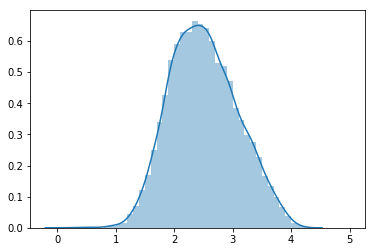

In [46]:
plot_pred(oof_train)

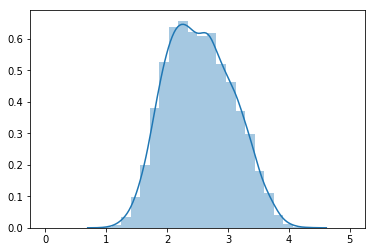

In [47]:
plot_pred(oof_test.mean(axis=1))

In [48]:
optR = OptimizedRounder()
optR.fit(oof_train, X_train['AdoptionSpeed'].values)
coefficients = optR.coefficients()
valid_pred = optR.predict(oof_train, coefficients)
qwk = quadratic_weighted_kappa(X_train['AdoptionSpeed'].values, valid_pred)
print("CV QWK = ", qwk)

CV QWK =  0.48074620158893455


In [49]:
coefficients_ = coefficients.copy()
coefficients_[0] = 1.66
coefficients_[1] = 2.13
coefficients_[3] = 2.85
train_predictions = optR.predict(oof_train, coefficients_).astype(np.int8)
print(f'train pred distribution: {Counter(train_predictions)}')
test_predictions = optR.predict(oof_test.mean(axis=1), coefficients_).astype(np.int8)
print(f'test pred distribution: {Counter(test_predictions)}')

train pred distribution: Counter({4: 4163, 2: 3412, 3: 3263, 1: 3246, 0: 909})
test pred distribution: Counter({4: 1156, 2: 893, 3: 883, 1: 860, 0: 156})


In [50]:
Counter(train_predictions)

Counter({2: 3412, 3: 3263, 1: 3246, 4: 4163, 0: 909})

In [51]:
Counter(test_predictions)

Counter({1: 860, 4: 1156, 3: 883, 2: 893, 0: 156})

In [52]:
submission = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': test_predictions})
submission.to_csv('submission.csv', index=False)
submission.head()

,PetID,AdoptionSpeed
0,378fcc4fc,1
1,73c10e136,4
2,72000c4c5,4
3,e147a4b9f,3
4,43fbba852,4
